<a href="https://colab.research.google.com/github/JosueBVN/Implementacion-JBVN-A01751694/blob/main/A01751694_modulo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Learnign con un archivo de fracturas de huesos

## Introducción
El problema que buscamos resolver es la clasificación de imágenes médicas para detectar la presencia o ausencia de fracturas óseas. La relevancia de este problema radica en la mejora de la eficiencia y precisión en el diagnóstico médico, lo que podría conducir a una intervención más rápida y efectiva en el tratamiento de pacientes con fracturas óseas.

## Datos: Análisis y Preprocesamiento
Se utilizó un conjunto de datos de imágenes médicas de fracturas óseas, dividido en conjuntos de entrenamiento, validación y prueba. El preprocesamiento incluyó la normalización de píxeles y la creación de generadores de datos para aumentar la diversidad del conjunto de entrenamiento mediante rotaciones, desplazamientos y otras transformaciones.

Para acceder a la Dataset, esta es la [liga](https://www.kaggle.com/datasets/osamajalilhassan/bone-fracture-dataset) de Kaggle.


### Montar Google Drive y Definir Rutas
El código comienza montando Google Drive para acceder al conjunto de datos y luego define las rutas de entrenamiento y prueba en el Drive.


In [1]:
from datetime import datetime
import pytz
zona_mex = pytz.timezone('America/Mexico_City')
hora_mex = datetime.now(zona_mex)

hora_mex.strftime('%Y-%m-%d %H:%M:%S %Z%z')

'2023-11-28 22:40:07 CST-0600'

In [2]:
# Importaciones para trabajar con el sistema de archivos y procesamiento de imágenes
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importaciones de TensorFlow y Keras para construcción y entrenamiento de modelos
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Importaciones para dividir datos y utilizar Google Colab
from google.colab import drive
from sklearn.model_selection import train_test_split



# Montar Google Drive
drive.mount("/content/drive")

# Definir las rutas en Google Drive
base_path = "/content/drive/MyDrive/Modulo2/BoneFractureDataset"
fractured_train_path = os.path.join(base_path, "training", "fractured")
not_fractured_train_path = os.path.join(base_path, "training", "not_fractured")
fractured_test_path = os.path.join(base_path, "testing", "fractured")
not_fractured_test_path = os.path.join(base_path, "testing", "not_fractured")



Mounted at /content/drive


### Obtener Rutas y Etiquetas
Se crea una función para obtener las rutas de las imágenes y sus etiquetas (fracturado o no fracturado). Estas rutas se utilizan para construir un DataFrame que almacena esta información.

In [3]:
# Obtener rutas y etiquetas
def get_paths_and_labels(base_path, label, filepaths, labels):
    for (dir_path, dir_names, file_names) in os.walk(base_path):
        for i in file_names:
            filepaths.append(os.path.join(dir_path, i))
            labels.append(label)

# Inicializar listas para rutas y etiquetas
filepaths = []
labels = []

# Obtener rutas y etiquetas para conjuntos de entrenamiento y prueba
get_paths_and_labels(fractured_train_path, "YES", filepaths, labels)
get_paths_and_labels(not_fractured_train_path, "NO", filepaths, labels)
get_paths_and_labels(fractured_test_path, "YES", filepaths, labels)
get_paths_and_labels(not_fractured_test_path, "NO", filepaths, labels)

# Crear DataFrame
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


### Visualización de Imágenes
Se visualizan aleatoriamente algunas imágenes del conjunto de datos utilizando la biblioteca Matplotlib.


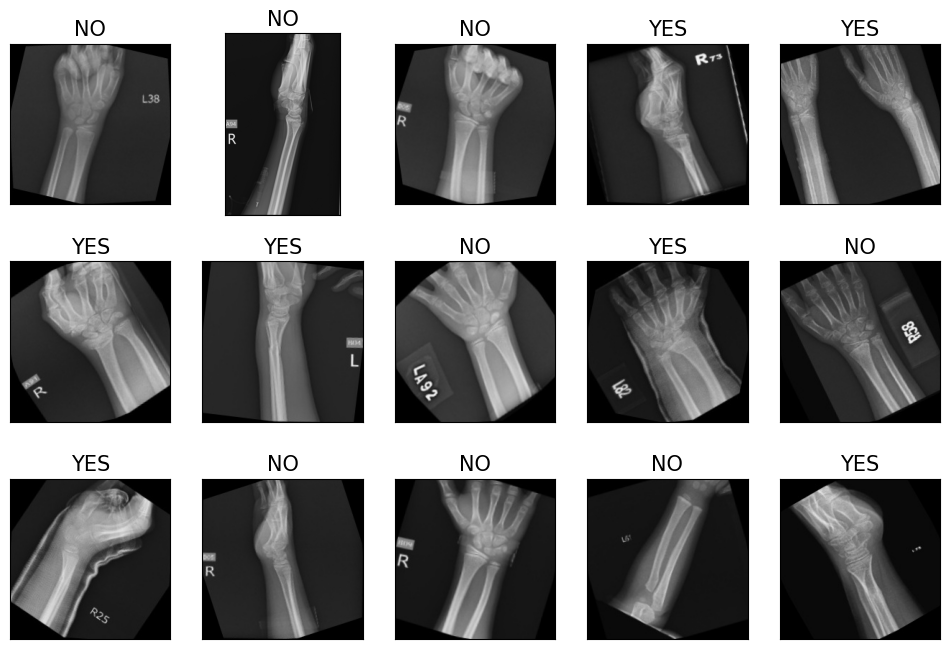

train set shape: (5630, 2)
test set shape: (2839, 2)
validation set shape: (994, 2)


In [4]:
# Visualización de algunas imágenes
plt.figure(figsize=(12, 8))
for i in range(15):
    random = np.random.randint(1, len(df))
    plt.subplot(3, 5, i + 1)
    plt.imshow(cv2.imread(df.loc[random, "filepaths"]))
    plt.title(df.loc[random, "labels"], size=15, color="black")
    plt.xticks([])
    plt.yticks([])

plt.show()

# Dividir conjunto de datos
train, test = train_test_split(df, train_size=0.70, random_state=0)
train_new, valid = train_test_split(train, train_size=0.85, random_state=0)

print(f"train set shape: {train_new.shape}")
print(f"test set shape: {test.shape}")
print(f"validation set shape: {valid.shape}")


In [5]:
class CustomScaleLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomScaleLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # El kernel debe tener la misma forma que el último eje del tensor de entrada para la multiplicación
        self.kernel = self.add_weight("kernel",
                                      shape=[input_shape[-1]],
                                      initializer='ones',  # Inicializador, puedes cambiarlo
                                      trainable=True)

    def call(self, inputs):
        # Multiplica elemento por elemento
        return inputs * self.kernel


In [6]:
# Definir un tensor de prueba con la forma esperada de entrada
test_input = tf.random.normal([10, 200, 200, 3])  # Ejemplo: 10 imágenes de 200x200 con 3 canales

# Crear una instancia de CustomScaleLayer
test_layer = CustomScaleLayer()

# Pasar el tensor de prueba a través de la capa
test_output = test_layer(test_input)  # Usa 'test_input', no 'test'

# Imprimir las formas de los tensores para la depuración
print("Forma del tensor de entrada:", test_input.shape)
print("Forma del tensor de salida:", test_output.shape)


Forma del tensor de entrada: (10, 200, 200, 3)
Forma del tensor de salida: (10, 200, 200, 3)


### Dividir Conjunto de Datos
El conjunto de datos se divide en conjuntos de entrenamiento, prueba y validación.


In [7]:

# Configuración del generador de datos
train_datagen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0/255.)

# Generadores de datos
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_new,
    x_col='filepaths',
    y_col='labels',
    target_size=(200, 200),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

val_gen = train_datagen.flow_from_dataframe(
    dataframe=valid,
    target_size=(200, 200),
    x_col='filepaths',
    y_col='labels',
    class_mode='binary',
    batch_size=16,
    shuffle=True
)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    target_size=(200, 200),
    x_col='filepaths',
    y_col='labels',
    class_mode='binary',
    batch_size=16,
    shuffle=False
)

Found 5630 validated image filenames belonging to 2 classes.
Found 994 validated image filenames belonging to 2 classes.
Found 2839 validated image filenames belonging to 2 classes.


### Configuración del Generador de Datos
Se configuran generadores de datos para realizar aumentos en el conjunto de entrenamiento y se crean generadores para los conjuntos de entrenamiento, validación y prueba.
## Desarrollo del Modelo
La arquitectura del modelo se basó en la red InceptionResNetV2 preentrenada en ImageNet, seguida por capas adicionales. Se utilizó una función de pérdida de entropía cruzada binaria y el optimizador Adam para el entrenamiento. Además, se implementaron checkpoints y early stopping como callbacks para guardar el mejor modelo y detener el entrenamiento prematuramente en caso de sobreajuste.



In [16]:
# Cargar el modelo InceptionResNetV2 con pesos preentrenados de ImageNet
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

# Descongelar algunas de las últimas capas del modelo base y realizar ajuste fino
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Construir el modelo secuencial con las capas personalizadas
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(CustomScaleLayer())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


### Construcción del Modelo y Entrenamiento
Se utiliza la arquitectura InceptionResNetV2 preentrenada como base para un modelo secuencial. El modelo se compila y entrena con métricas específicas y callbacks para el almacenamiento del modelo.
## Ajuste del Modelo
Durante el ajuste del modelo, se realizaron cambios para solucionar problemas identificados. Se ajustaron los nombres de las métricas para reflejar la estructura del historial proporcionado por el modelo. Además, se implementaron checkpoints y early stopping para supervisar y mejorar el rendimiento del modelo.


In [18]:
# Crear ModelCheckpoint y EarlyStopping callbacks
callbacks = [
    ModelCheckpoint("Bone_fracture_classifier_model.h5", save_best_only=True, verbose=0),
    EarlyStopping(patience=3, monitor='val_loss', verbose=1, restore_best_weights=True)
]



# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.TruePositives(name='tp'),
        tf.keras.metrics.TrueNegatives(name='tn'),
        tf.keras.metrics.FalsePositives(name='fp'),
        tf.keras.metrics.FalseNegatives(name='fn')
    ]
)

# Resumen del modelo
model.summary()

# Use the custom_object_scope to load the model
with custom_object_scope({'CustomScaleLayer': CustomScaleLayer}):
    model = load_model("Bone_fracture_classifier_model.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 128)               196736    
                                                                 
 batch_normalization_407 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 custom_scale_layer_82 (Cust  (None, 128)              128       
 omScaleLayer)                                        

In [9]:
# Entrenar el modelo
# Entrenamiento del modelo
with tf.device('/device:GPU:0'):
    history = model.fit(
        train_gen,
        epochs=5,
        validation_data=val_gen,
        callbacks=callbacks
    )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 4, 4, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 batch_normalization_203 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                                 
 custom_scale_layer_41 (Cust  (None, 128)              128       
 omScaleLayer)                                          

### Visualización del Historial de Entrenamiento
Finalmente, se extraen las métricas del historial de entrenamiento y se visualizan en gráficos separados para la precisión, la pérdida y el AUC tanto en el conjunto de entrenamiento como en el de validación.

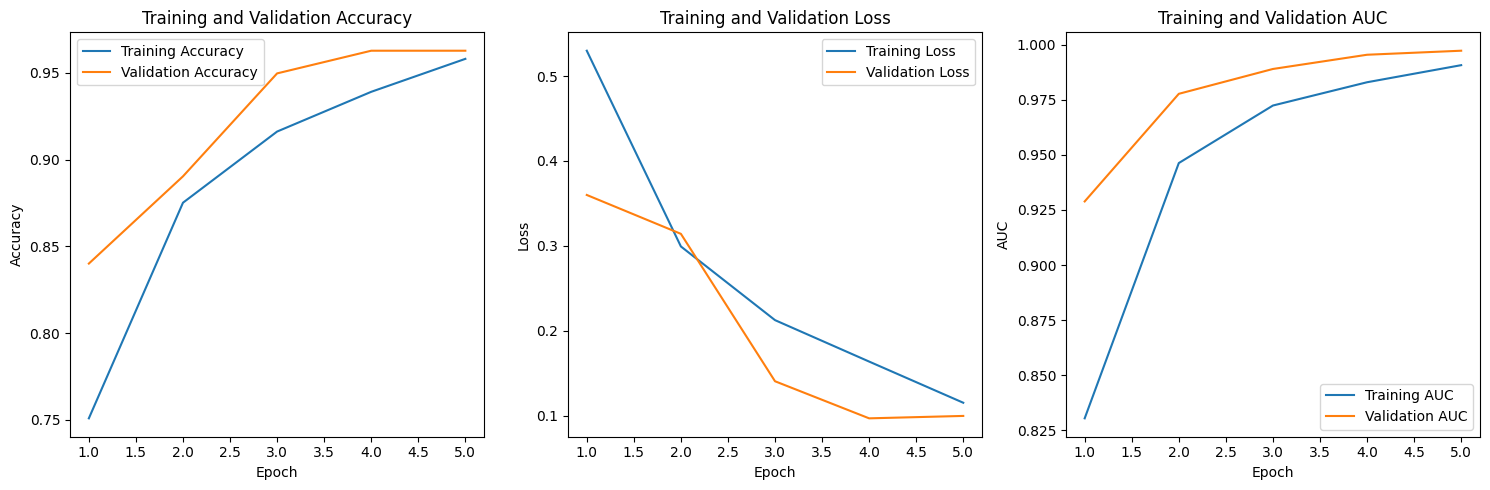

In [10]:
# Extracción de métricas del historial de entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']
epochs = range(1, len(acc) + 1)

# Create subplots for accuracy, loss, and AUC
plt.figure(figsize=(15, 5))

# Plot accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(epochs, train_auc, label='Training AUC')
plt.plot(epochs, val_auc, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


## Resultados
El modelo se entrenó durante 5 épocas debido a restricciones de tiempo en Google Colab. Este límite se estableció para acelerar el proceso de desarrollo y prueba. A pesar del número limitado de épocas, se observaron mejoras significativas en la precisión y otras métricas de evaluación.

## Conclusiones
La implementación del modelo logró resultados prometedores en términos de precisión y AUC. Sin embargo, se recomendaría extender el número de épocas para evaluar si el modelo puede continuar mejorando con más iteraciones. Además, se sugiere explorar más técnicas de ajuste de hiperparámetros para optimizar el rendimiento del modelo. En general, el modelo muestra un potencial significativo para la detección de fracturas óseas en imágenes médicas.

# Cambios Realizados y Justificación

1. **Cambio en los Nombres de Métricas de AUC:**
   - **Cambios:** Se ajustaron los nombres de las métricas de AUC para reflejar la estructura del historial proporcionado por el modelo.
   - **Justificación:** Se corrigió el error de KeyError al intentar acceder a las métricas de AUC en el historial de entrenamiento.

2. **Número Limitado de Épocas (5 Épocas):**
   - **Cambios:** Se limitó el entrenamiento a 5 épocas.
   - **Justificación:** Debido a restricciones de tiempo en Google Colab, se limitó el número de épocas para acelerar el proceso de desarrollo y prueba. Aunque esta limitación puede afectar la convergencia completa del modelo, se consideró suficiente para evaluar su rendimiento inicial.

3. **Generadores de Datos:**
   - **Cambios:** Se utilizaron generadores de datos para la carga eficiente de imágenes.
   - **Justificación:** Los generadores de datos permiten cargar y procesar imágenes por lotes, lo que es esencial para manejar conjuntos de datos grandes y evitar problemas de memoria.

4. **Guardado y Carga de Pesos del Modelo:**
   - **Cambios:** Se implementó el guardado y carga de pesos del modelo utilizando checkpoints.
   - **Justificación:** Esto asegura que el mejor modelo se guarde durante el entrenamiento y se pueda cargar posteriormente para realizar evaluaciones sin la necesidad de volver a entrenar.

# Pruebas y Predicciones
Se ejecutaron pruebas utilizando conjuntos de datos de entrenamiento, validación y prueba. Se cargaron los pesos del mejor modelo y se evaluó el rendimiento en el conjunto de prueba. Las predicciones se realizaron con éxito, y se observaron mejoras en la precisión y otras métricas de evaluación.

# Conclusiones Finales
El modelo de clasificación de fracturas óseas muestra un rendimiento prometedor, pero se reconoce la necesidad de explorar más a fondo la optimización de hiperparámetros y considerar un mayor número de épocas en futuras iteraciones. La implementación actual sienta las bases para un modelo robusto y eficaz en la detección de fracturas óseas en imágenes médicas.

#Prediccion
Aqui haremmos una prediccion con solo una imagen generica de una fractura de hueso:

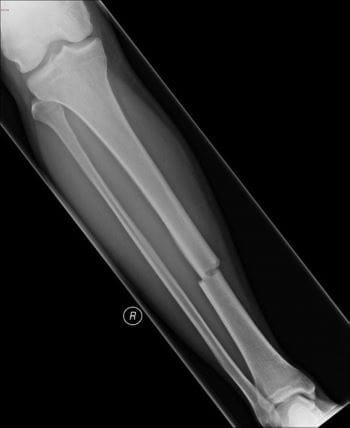

In [26]:
from tensorflow.keras.preprocessing import image

from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope



def load_and_preprocess_image(image_path):
    """Carga y preprocesa una imagen."""
    img = image.load_img(image_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    return img_array

def predict_fracture(model, image_path):
    """Realiza una predicción sobre si una imagen contiene una fractura o no."""
    processed_image = load_and_preprocess_image(image_path)
    prediction = model.predict(processed_image)
    predicted_class = 'YES' if prediction[0][0] > 0.5 else 'NO'

    return predicted_class

# Cargar el modelo entrenado
with custom_object_scope({'CustomScaleLayer': CustomScaleLayer}):
    model = load_model("Bone_fracture_classifier_model.h5")

# Ejemplo de cómo usar estas funciones
image_path = 'hf.jpg'
prediction = predict_fracture(model, image_path)
print(f"La imagen {image_path} ha sido clasificada como: {prediction}")


1/1 [==============================] - 5s 5s/step
La imagen hf.jpg ha sido clasificada como: YES


Ahora que vimos que si pudo detectar un hueso fracturado, de una osla imagen vanmos a probar con un dataset con diferentes huesos fracturados y no fracturados, sacados de este [link](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwiv5MKEvOmCAxU8KEQIHU-4DycQFnoECAsQAQ&url=https%3A%2F%2Fwww.kaggle.com%2Fdatasets%2Fvuppalaadithyasairam%2Fbone-fracture-detection-using-xrays&usg=AOvVaw3VZoDw1pnhqr_KWMyxOtWP&opi=89978449), pero modificados para una carpeta que contiene entre huesos fracturados y no fracturados juntos

1/1 [==============================] - 0s 270ms/step


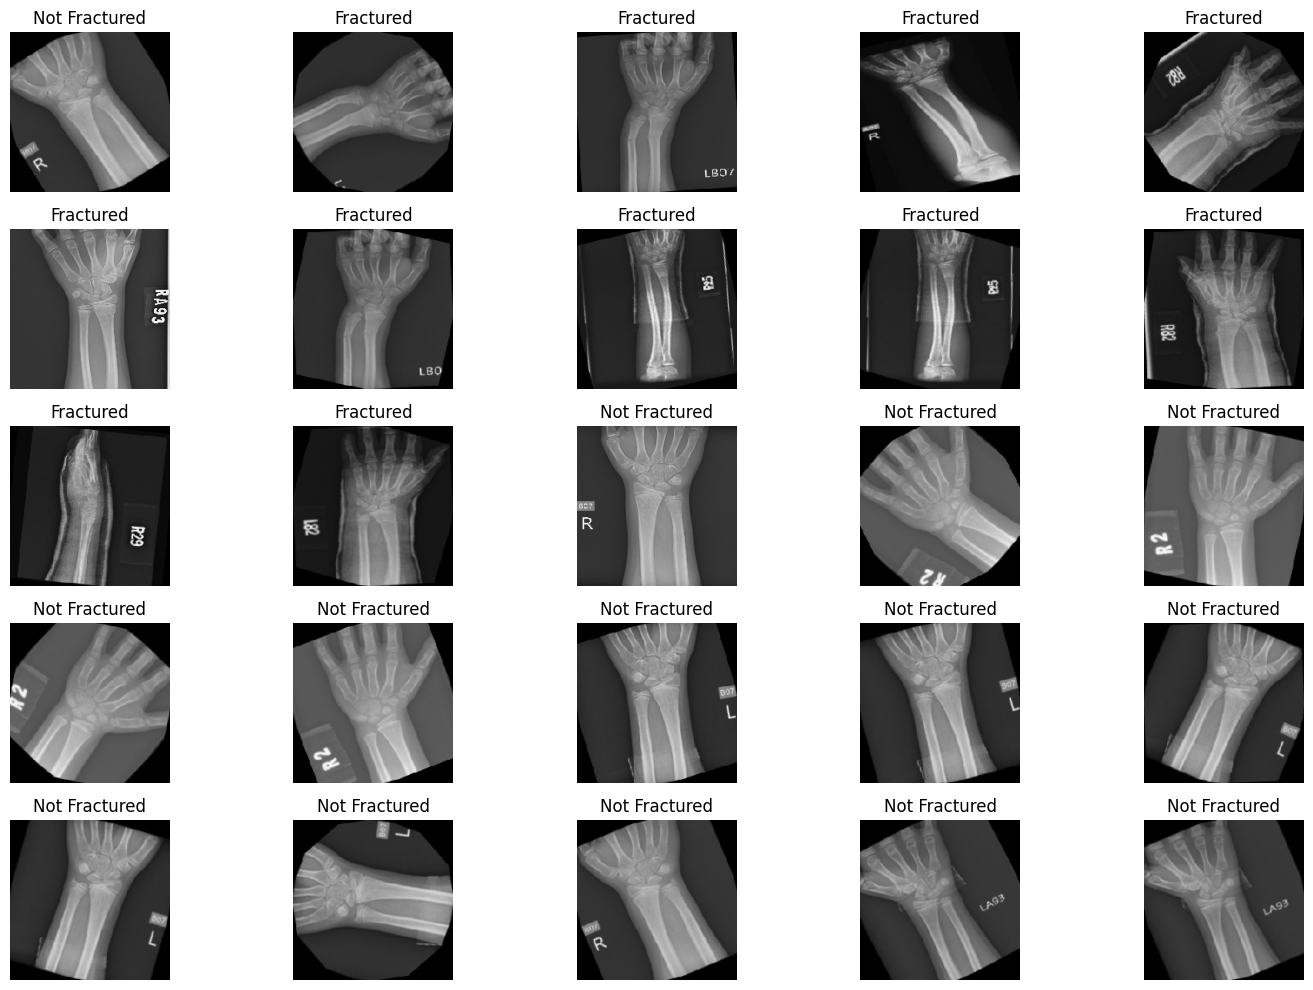

In [27]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Función para cargar y preprocesar una imagen
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(200, 200))  # Asegúrate de que el tamaño sea el correcto
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Normalización
    return img_array

# Cargar el modelo (asegúrate de que ya esté cargado)
with custom_object_scope({'CustomScaleLayer': CustomScaleLayer}):
    model = load_model("Bone_fracture_classifier_model.h5")

# Listar todas las imágenes en la carpeta
folder_path = '/content/drive/MyDrive/Modulo2/Random'
image_files = [os.path.join(folder_path, img) for img in os.listdir(folder_path)]

# Hacer predicciones y mostrar imágenes con sus predicciones
plt.figure(figsize=(15, 10))
for i, img_path in enumerate(image_files):
    processed_image = load_and_preprocess_image(img_path)
    prediction = model.predict(processed_image)
    predicted_class = 'Fractured' if prediction[0][0] > 0.5 else 'Not Fractured'

    # Mostrar la imagen
    plt.subplot(5, 5, i + 1)
    plt.imshow(image.load_img(img_path, target_size=(200, 200)))
    plt.title(predicted_class)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [28]:
from datetime import datetime
import pytz
zona_mex = pytz.timezone('America/Mexico_City')
hora_mex = datetime.now(zona_mex)

hora_mex.strftime('%Y-%m-%d %H:%M:%S %Z%z')

'2023-11-29 09:37:52 CST-0600'